In [1]:
from poincare_maps import *
# from analysis import *

import scanpy.api as sc
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import *

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics.pairwise import pairwise_distances

def get_scores(true_lineages, labels):
    ARS = metrics.adjusted_rand_score(true_lineages, labels)
    FMS = metrics.fowlkes_mallows_score(true_lineages, labels)
    print(f"ARI = {ARS:.2f}")
    print(f"FMS = {FMS:.2f}")
    
    return ARS, FMS

def run_comparison():
    name_list = []
    score_list = []
    
    print('louvain')
    name_list.append('louvain')
    score_list.append(get_scores(true_lineages, louvain_labels))
    model.plot('rot', labels=louvain_labels, file_name=fout + '_ori', title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))

    N = len(np.unique(louvain_labels))
    print('Poincaré ward')
    name_list.append('Poincaré ward')
    model.detect_cluster(n_clusters=N, clustering_name='ward', k=20)
    score_list.append(get_scores(true_lineages, model.clusters))
    
    print('Poincaré kmedoids')
    model.detect_cluster(n_clusters=N, clustering_name='kmedoids', k=20)
    model.plot('rot', labels=model.clusters, file_name=fout + '_ori', title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))
    name_list.append('Poincaré kmedoids')
    score_list.append(get_scores(true_lineages, model.clusters))
    
    print('Poincaré spectral')
    model.detect_cluster(n_clusters=N, clustering_name='spectral', k=20)
    name_list.append('Poincaré spectral')
    score_list.append(get_scores(true_lineages, model.clusters))
    
    clustering = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=N).fit(data)
    print('Euclidean ward')
    name_list.append('Euclidean ward')
    model.plot('rot', labels=clustering.labels_, file_name=fout + '_ori', title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))
    score_list.append(get_scores(true_lineages, clustering.labels_))
    
    clustering = AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=N).fit(data)
    print('Euclidean average')
    name_list.append('Euclidean average')
    model.plot('rot', labels=clustering.labels_, file_name=fout + '_ori', title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))
    score_list.append(get_scores(true_lineages, clustering.labels_))
    
    spectral = SpectralClustering(
        n_clusters=N, eigen_solver='arpack',
        affinity="nearest_neighbors").fit(data)
    print('Euclidean spectral')
    name_list.append('Euclidean spectral')
    model.plot('rot', labels=spectral.labels_, file_name=fout + '_ori', title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))
    score_list.append(get_scores(true_lineages, spectral.labels_))
    
    two_means = MiniBatchKMeans(n_clusters=N).fit(data)
    print('Euclidean kmeans')
    name_list.append('Euclidean kmeans')
    model.plot('rot', labels=two_means.labels_, file_name=fout + '_ori', title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))
    score_list.append(get_scores(true_lineages, two_means.labels_))
    
    return name_list, score_list


In [2]:
from kmedoids import *

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=15, distances='Poincaré'):
    
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
                                             affinity='precomputed').fit(D)
        labels = clustering.labels_
    
    scores = get_scores(true_lineages, labels)
    model.plot('rot', labels=labels, file_name=fout + '_' + clustering_name + '_' + distances, 
               title_name=f"{clustering_name} {distances}\nARI = {scores[0]:.2f}, FMS = {scores[1]:.2f}", 
               zoom=None, bbox=(1.1, 0.8))
    
    title = f"{clustering_name} {distances}"
    return scores, title

... storing 'labels' as categorical


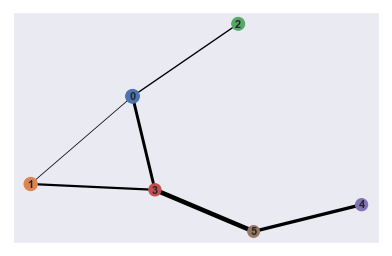

In [3]:
model_name = 'ToggleSwitch'
col_dict = None

fin = f"datasets/{model_name}"
fout = f"benchmarks/{model_name}"

data, true_labels, col_names = read_data(fin, normalize=False, n_pca=0)
adata, iroot, louvain_labels = init_scanpy(data, col_names, 'root', true_labels, fout, k=15, n_pcs=0)

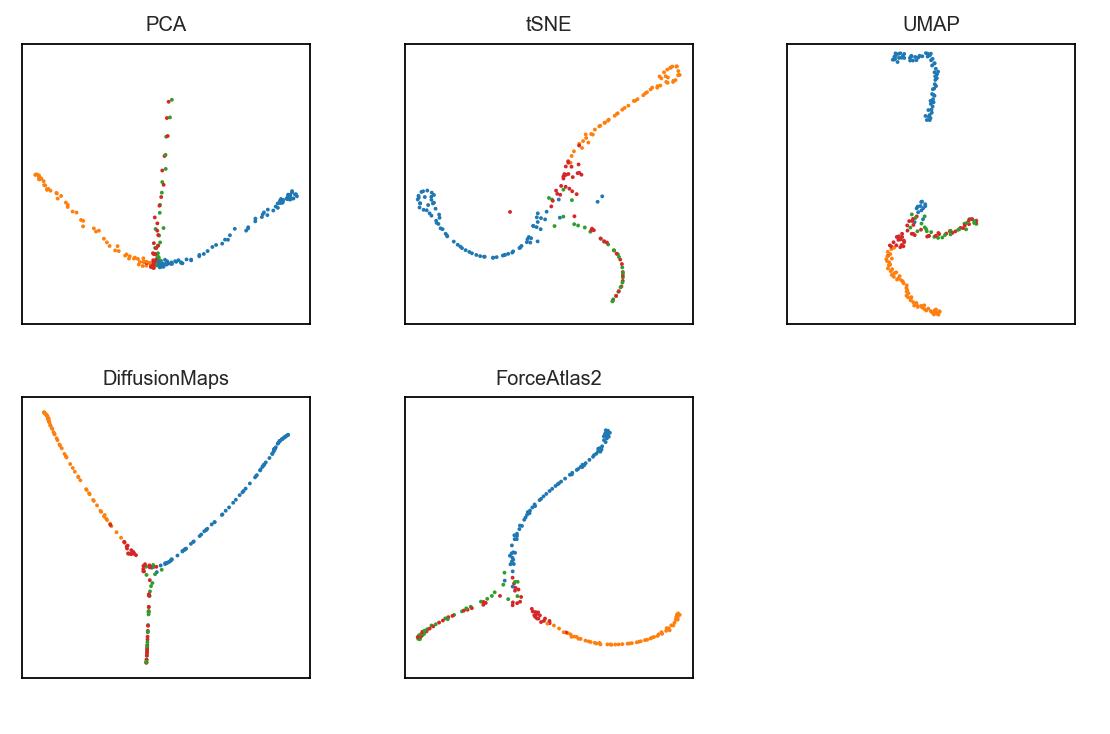

In [4]:
true_lineages = true_labels
true_lineages[true_lineages == 'root'] = 'inter1'
# true_lineages[true_lineages == 'inter1'] = 'branch1'
# true_lineages[true_lineages == 'inter2'] = 'branch2'

fsetting = 'ToggleSwitch_MFIsym15_klSym_sigma=1.00_gamma=2.00_lr=0.02_lrm=1.00_pca=20_epochs=10000_batchsize=25_connected'
input_file = f"results/{fsetting}"
poincare_coord = pd.read_csv(input_file + '.csv', sep=',', header=None).values
model = PoincareMaps(poincare_coord)
model.iroot = iroot
model.rotate()
model.get_distances()
plotBenchamrks(adata, true_labels, f"benchmarks/{model_name}")

In [5]:
def get_clustering_score_table():
    nc = len(np.unique(louvain_labels))
    scores = []
    titles = []
    scores.append(get_scores(true_lineages, louvain_labels))
    titles.append('louvain')

    model.plot('rot', labels=louvain_labels, file_name=fout + '_louvain', 
                   title_name=f"louvain", 
                   zoom=None, bbox=(1.1, 0.8))


    for cname in ['spectral', 'agglomerative', 'kmedoids']:
        s, t = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname, k=15, distances='Poincaré')
        scores.append(s)
        titles.append(t)

    for cname in ['spectral', 'agglomerative', 'kmedoids']:
        s, t = detect_cluster(pairwise_distances(data), 
                              n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        scores.append(s)
        titles.append(t)
            
    title_name_dict = {'X_pca': 'PCA',
                       'X_tsne': 'tSNE',
                       'X_umap': 'UMAP', 
                       'X_diffmap': 'DiffusionMaps', 
                       'X_draw_graph_fa': 'ForceAtlas2'}

    for embedding_name in ['X_pca', 'X_tsne', 'X_umap', 'X_diffmap', 'X_draw_graph_fa']:
        for cname in ['spectral', 'agglomerative', 'kmedoids']:
            s, t = detect_cluster(pairwise_distances(adata.obsm[embedding_name]), 
                                  n_clusters=nc, clustering_name=cname, k=15, distances=title_name_dict[embedding_name])
            scores.append(s)
            titles.append(t)
            
    return titles, scores

ARI = 0.46
FMS = 0.59
ARI = 0.39
FMS = 0.54
ARI = 0.49
FMS = 0.61
ARI = 0.38
FMS = 0.53
ARI = 0.18
FMS = 0.39
ARI = 0.12
FMS = 0.42
ARI = 0.19
FMS = 0.41
ARI = 0.18
FMS = 0.39
ARI = 0.12
FMS = 0.42
ARI = 0.20
FMS = 0.42
ARI = 0.45
FMS = 0.58
ARI = 0.45
FMS = 0.59
ARI = 0.44
FMS = 0.57
ARI = 0.37
FMS = 0.52
ARI = 0.37
FMS = 0.52
ARI = 0.31
FMS = 0.48
ARI = 0.55
FMS = 0.66
ARI = 0.04
FMS = 0.39
ARI = 0.06
FMS = 0.36
ARI = 0.00
FMS = 0.53
ARI = 0.48
FMS = 0.61
ARI = 0.42
FMS = 0.56


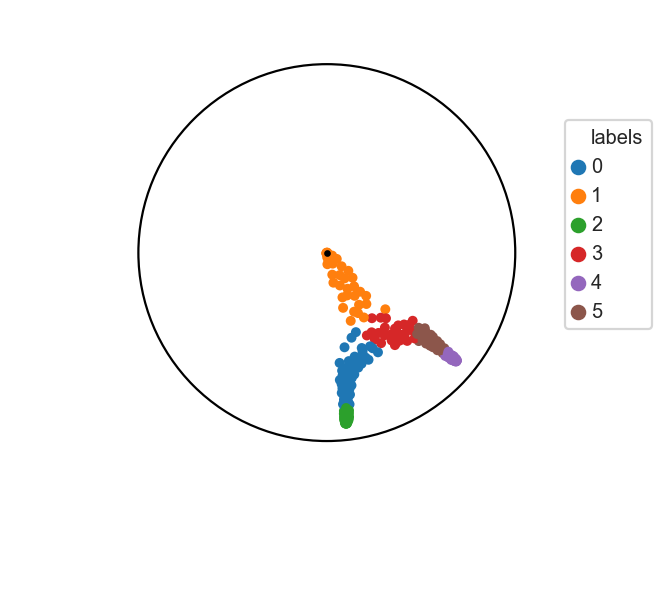

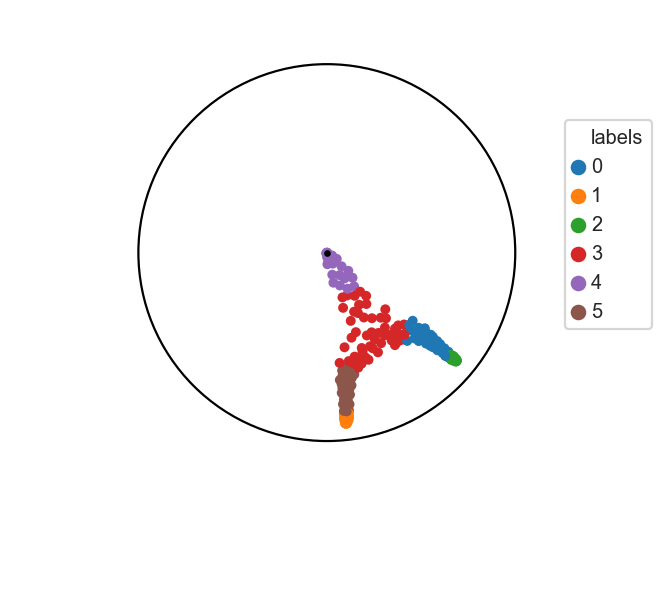

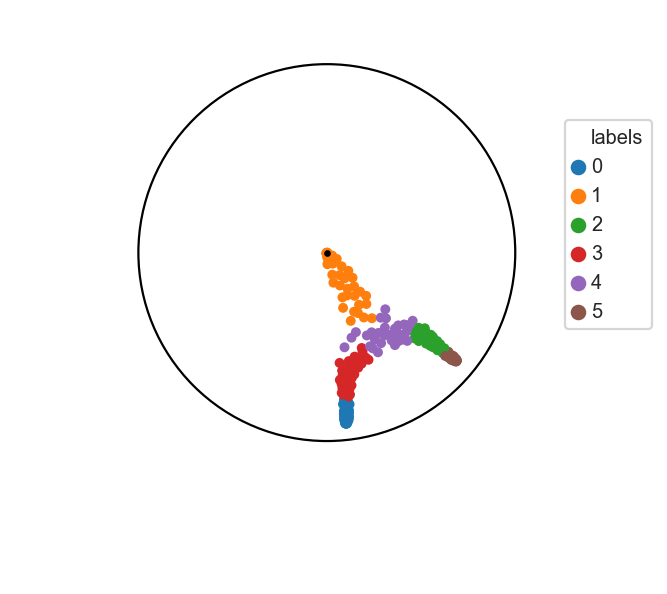

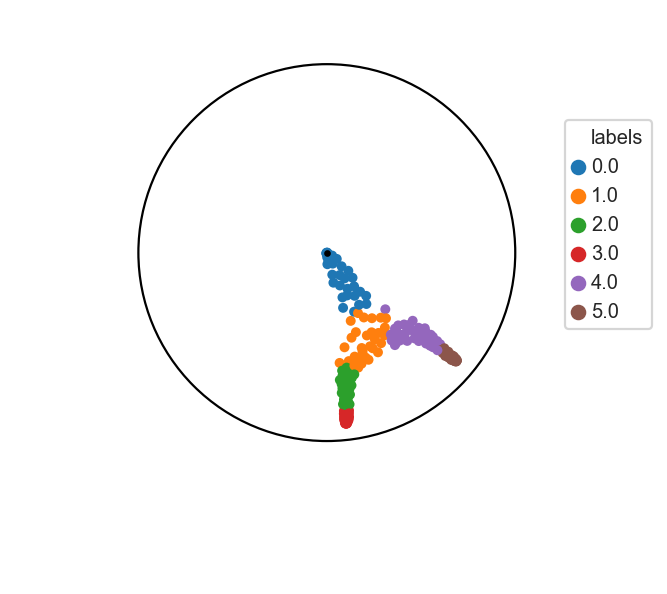

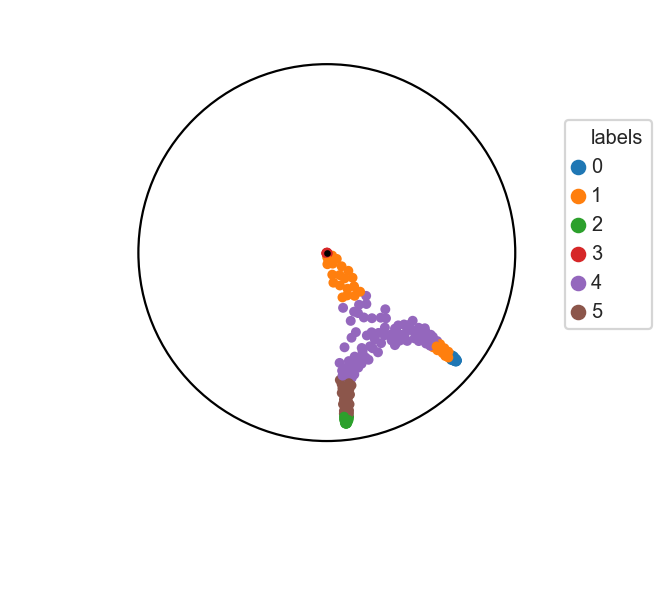

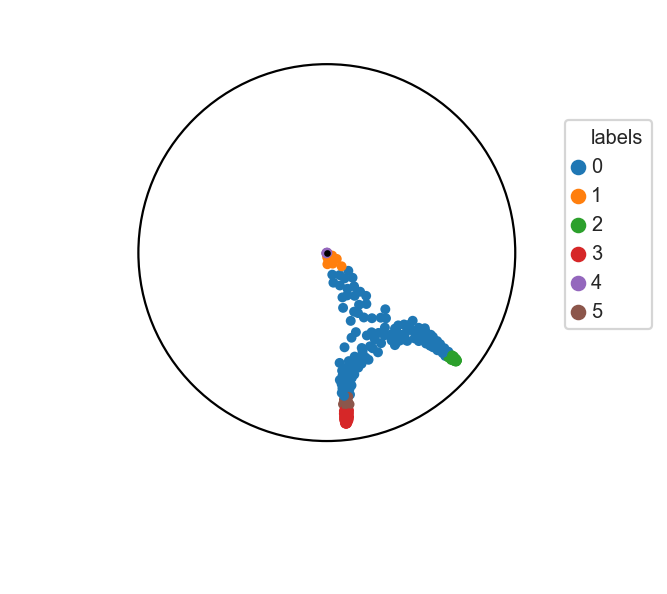

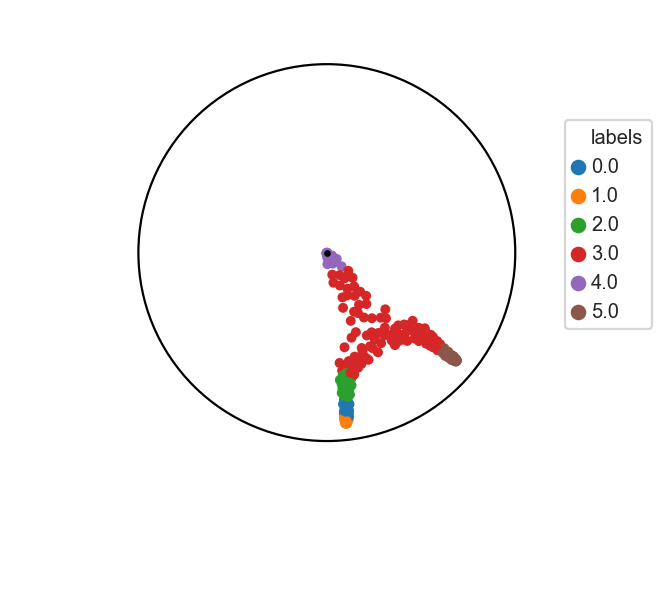

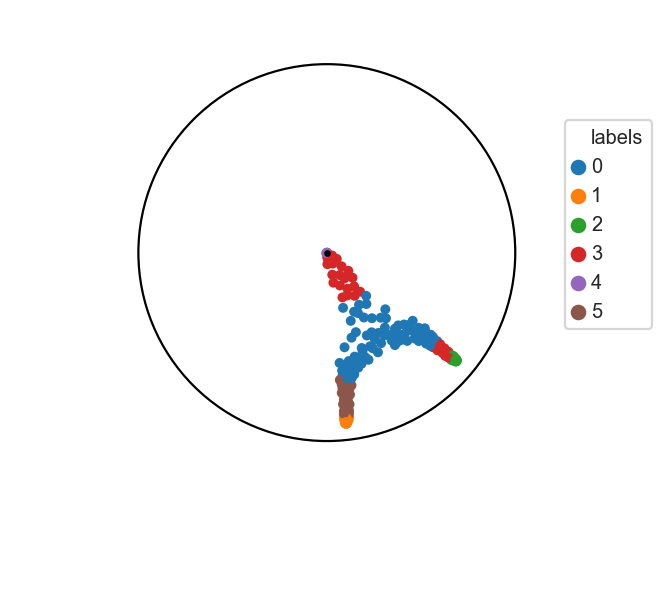

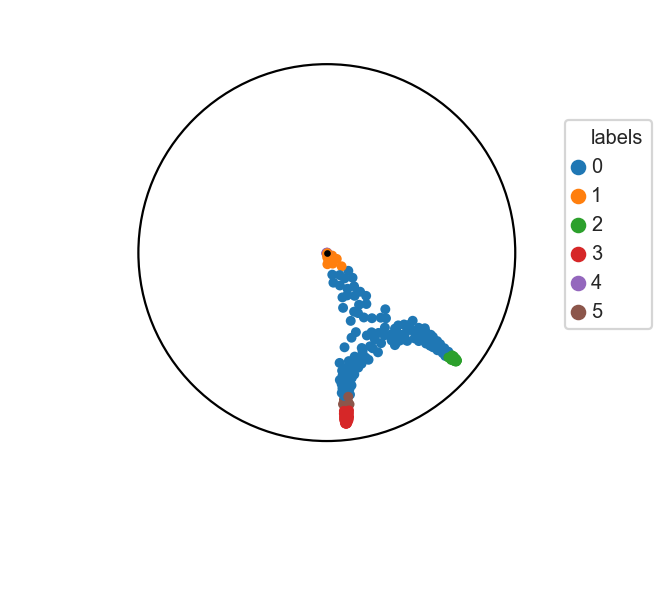

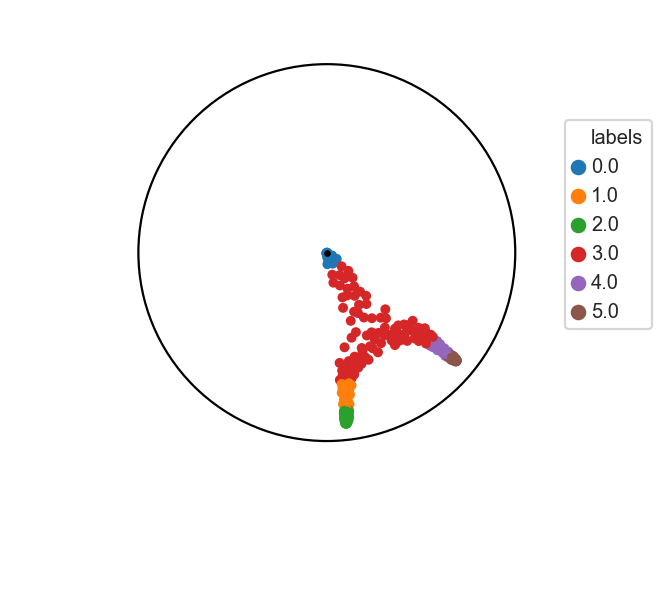

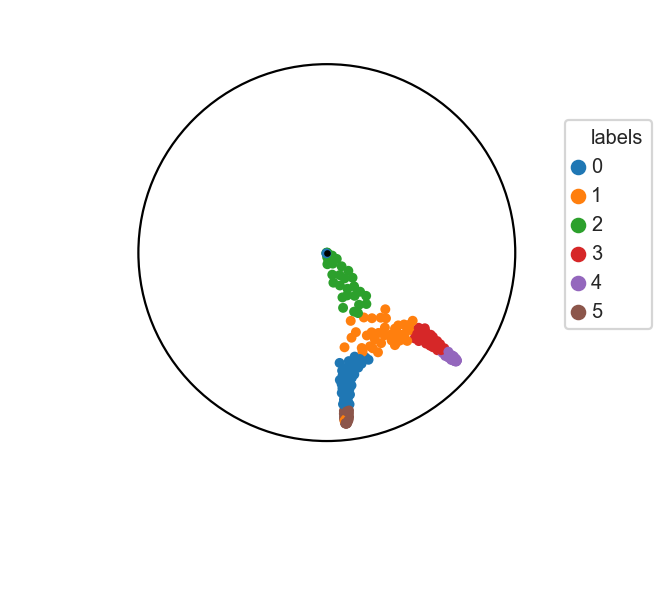

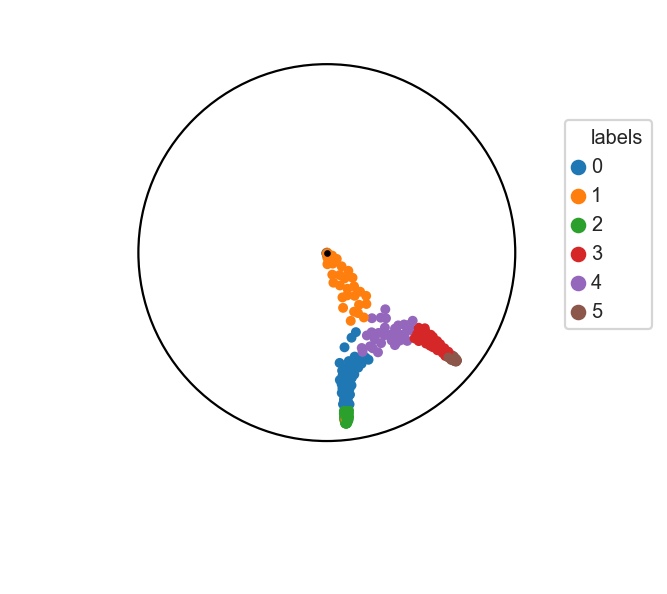

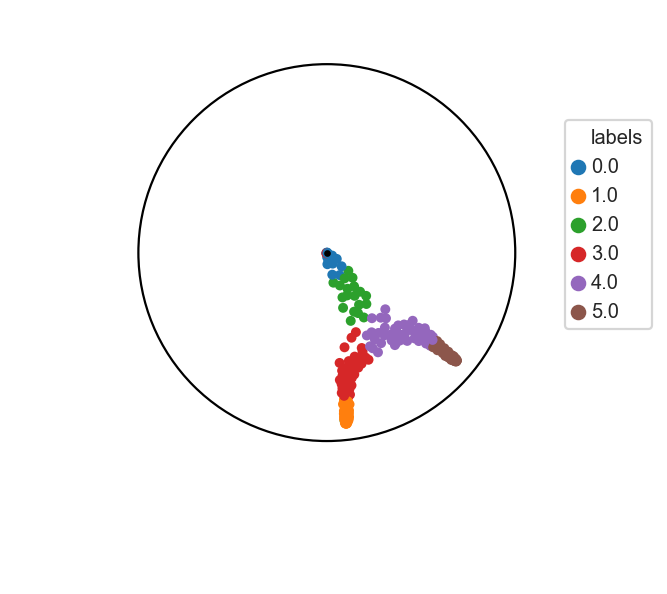

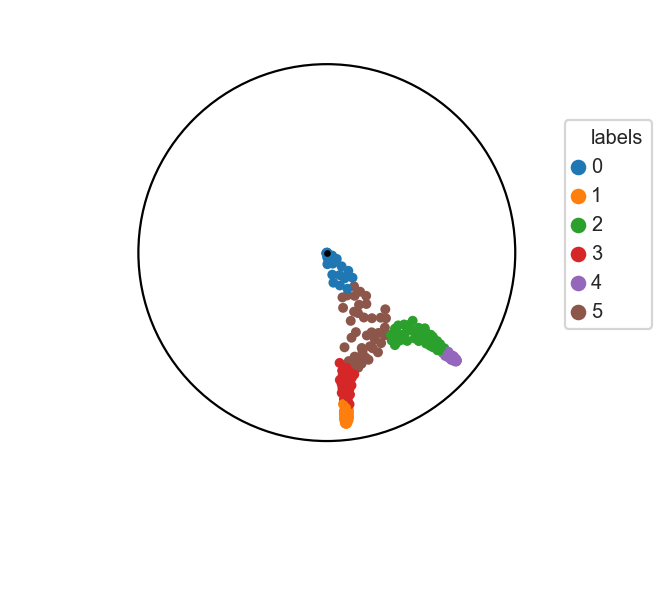

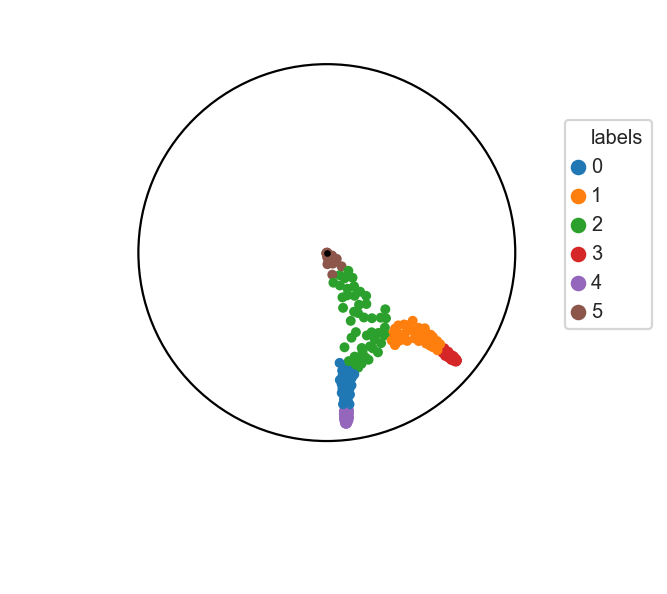

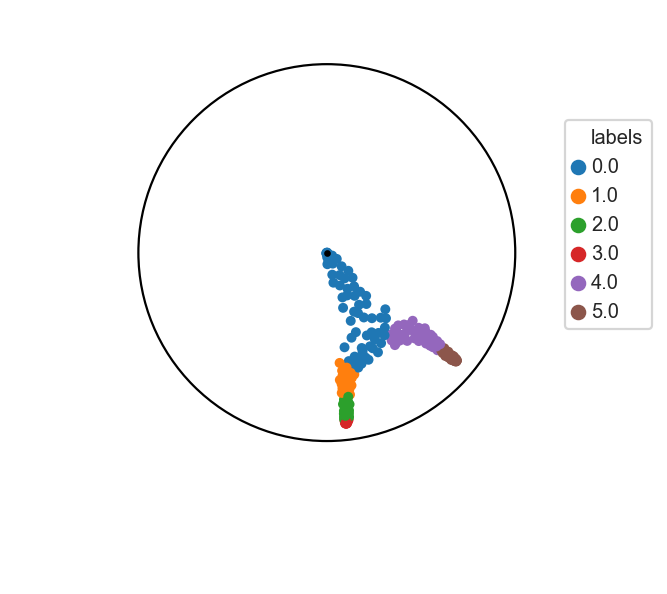

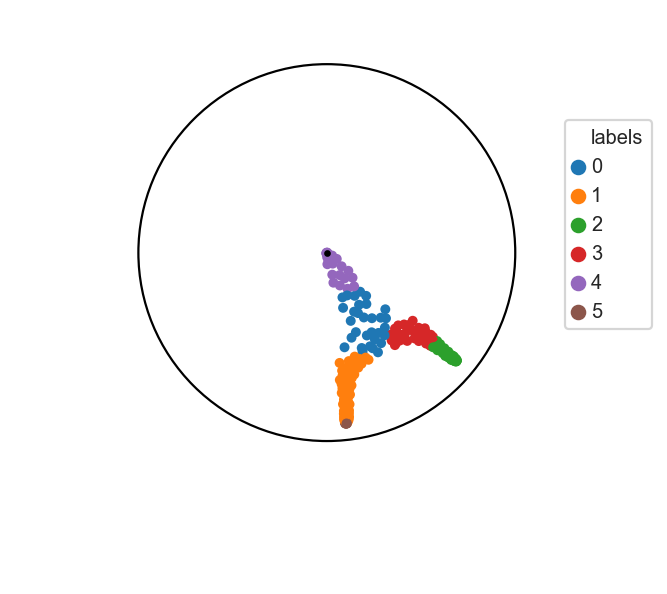

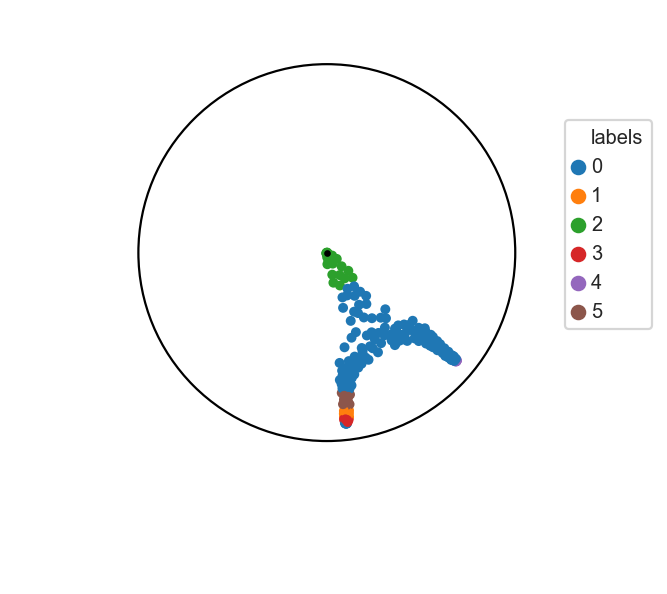

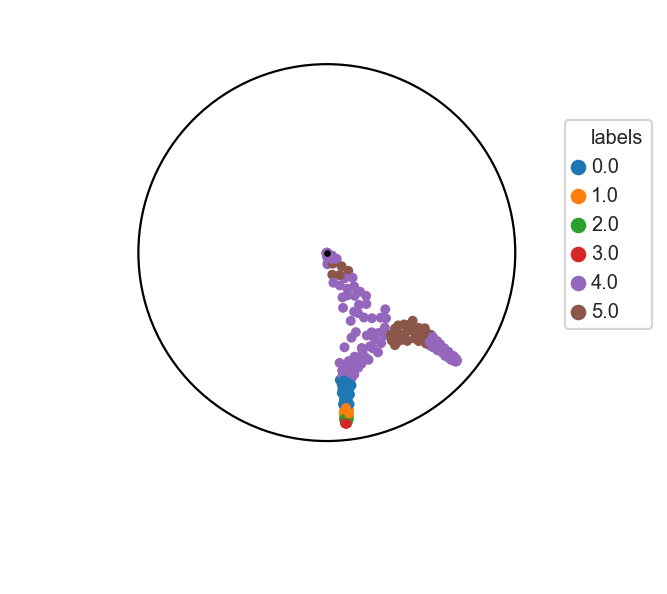

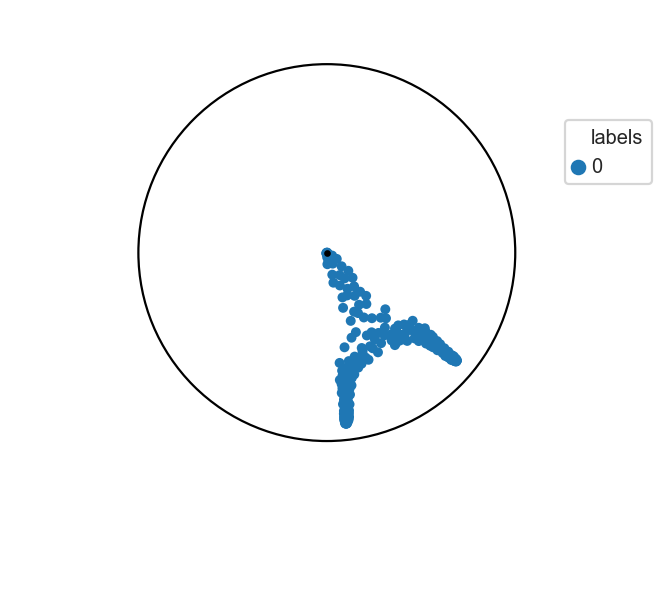

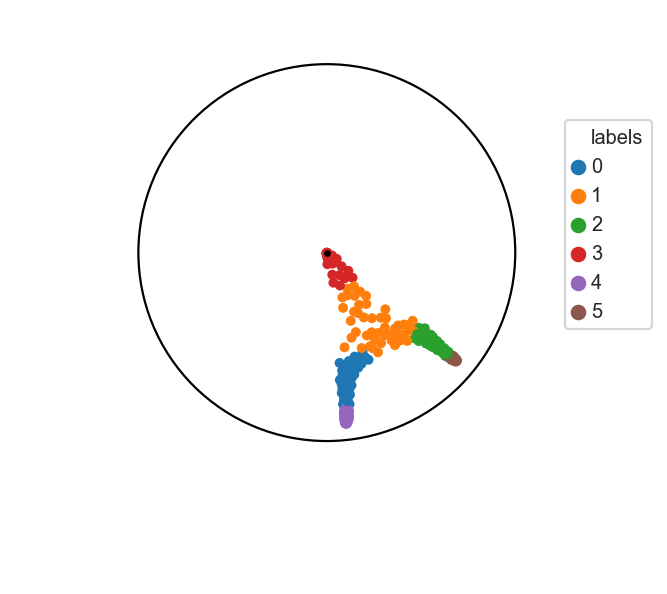

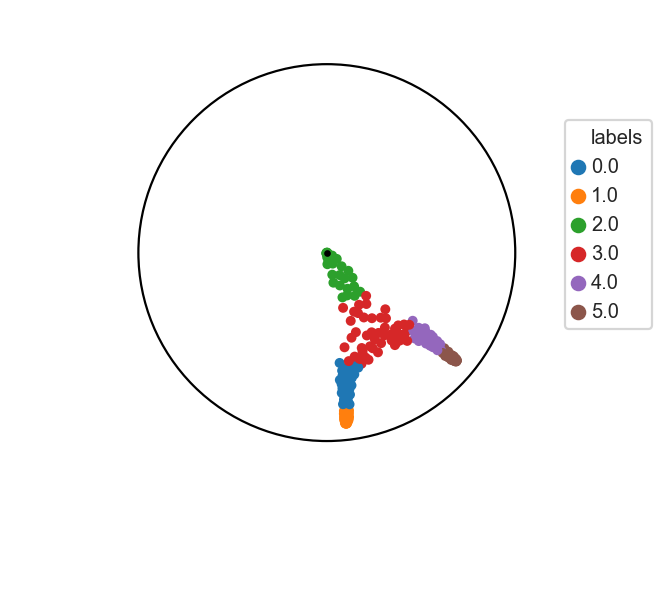

In [6]:
titles, scores1 = get_clustering_score_table()

# MyeloidProgenitors

... storing 'labels' as categorical


saving figure to file benchmarks/ToggleSwitch/paga.pdf


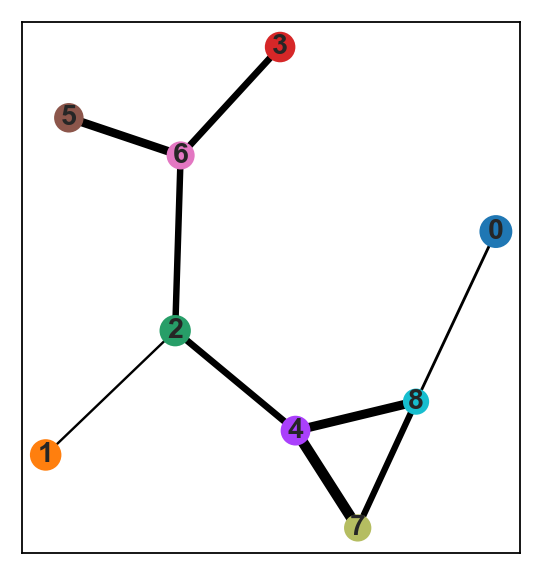

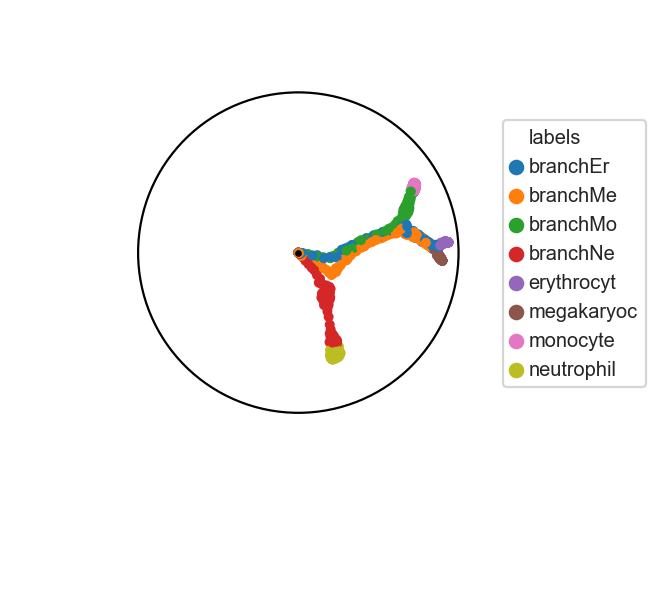

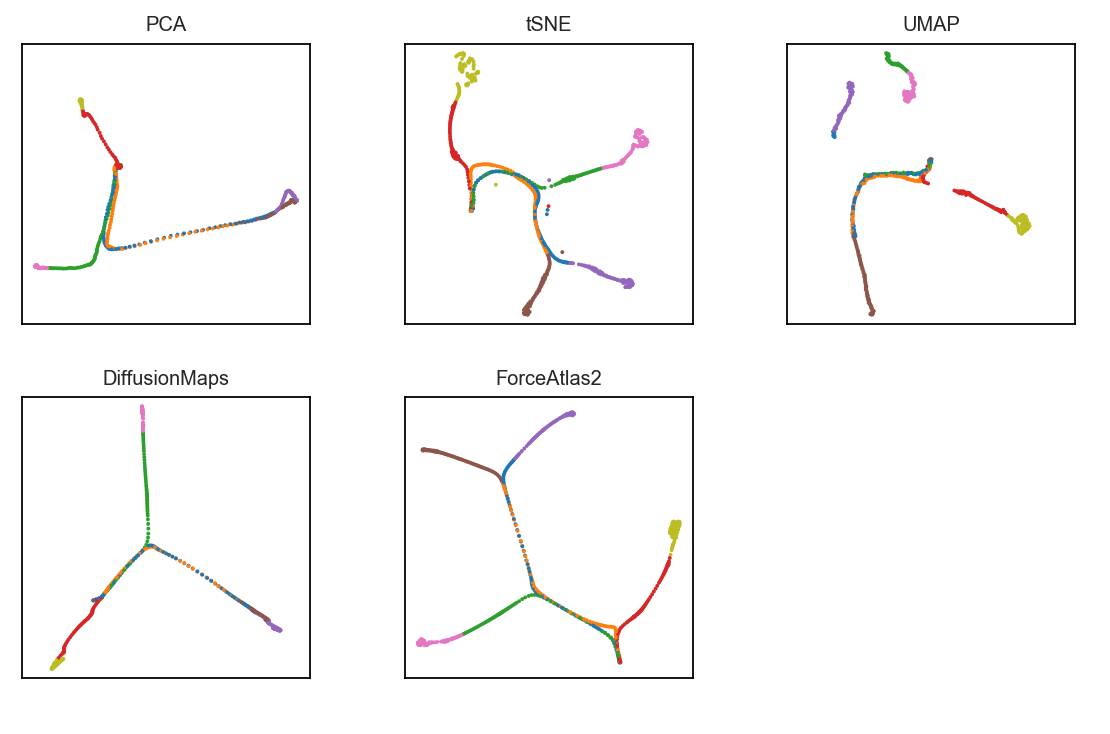

In [7]:
model_name = 'MyeloidProgenitors'
col_dict = None


fin = f"datasets/{model_name}"
fout = f"benchmarks/{model_name}"

data, true_labels, col_names = read_data(fin, normalize=False, n_pca=0)
adata, iroot, louvain_labels = init_scanpy(data, col_names, 'root', true_labels, fout, k=30)
true_labels[true_labels == 'root'] = 'branchMo'
# true_labels[true_labels == 'branchMo'] = 'monocyte'
# true_labels[true_labels == 'branchEr'] = 'erythrocyt'
# true_labels[true_labels == 'branchMk'] = 'megakaryoc'
# true_labels[true_labels == 'branchNe'] = 'neutrophil'
true_lineages = true_labels

fsetting = 'MyeloidProgenitors_MFIsym30_klSym_sigma=2.00_gamma=2.00_lr=0.05_lrm=1.00_pca=0_epochs=10000_batchsize=80_connected'
input_file = f"results/{fsetting}"
poincare_coord = pd.read_csv(input_file + '.csv', sep=',', header=None).values
model = PoincareMaps(poincare_coord)
model.iroot = iroot
model.rotate()
model.get_distances()

fs=9
model.plot('rot', labels=true_labels, file_name=fout + '_ori', 
           d1=4.5, d2=4.0,
           title_name='Poincaré map', zoom=None, bbox=(1.1, 0.8))

plotBenchamrks(adata, true_labels, f"benchmarks/{model_name}")

ARI = 0.58
FMS = 0.63
ARI = 0.62
FMS = 0.67
ARI = 0.57
FMS = 0.62
ARI = 0.54
FMS = 0.60
ARI = 0.52
FMS = 0.58
ARI = 0.54
FMS = 0.60
ARI = 0.55
FMS = 0.61
ARI = 0.53
FMS = 0.59
ARI = 0.48
FMS = 0.55
ARI = 0.49
FMS = 0.56
ARI = 0.61
FMS = 0.66
ARI = 0.54
FMS = 0.59
ARI = 0.43
FMS = 0.52
ARI = 0.47
FMS = 0.54
ARI = 0.52
FMS = 0.58
ARI = 0.58
FMS = 0.63
ARI = 0.52
FMS = 0.58
ARI = 0.11
FMS = 0.31
ARI = 0.42
FMS = 0.50
ARI = -0.00
FMS = 0.30
ARI = 0.56
FMS = 0.61
ARI = 0.55
FMS = 0.61


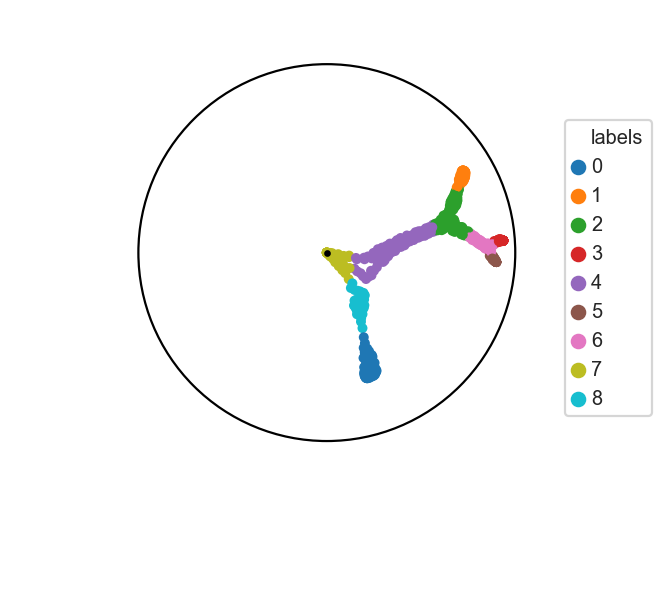

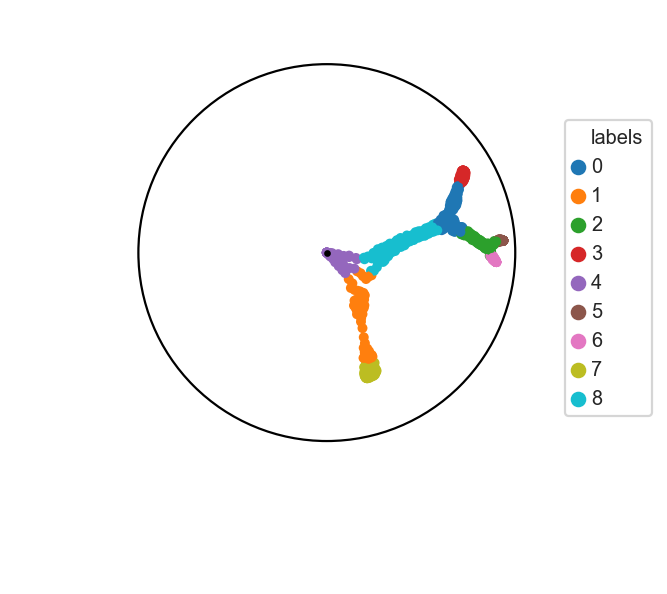

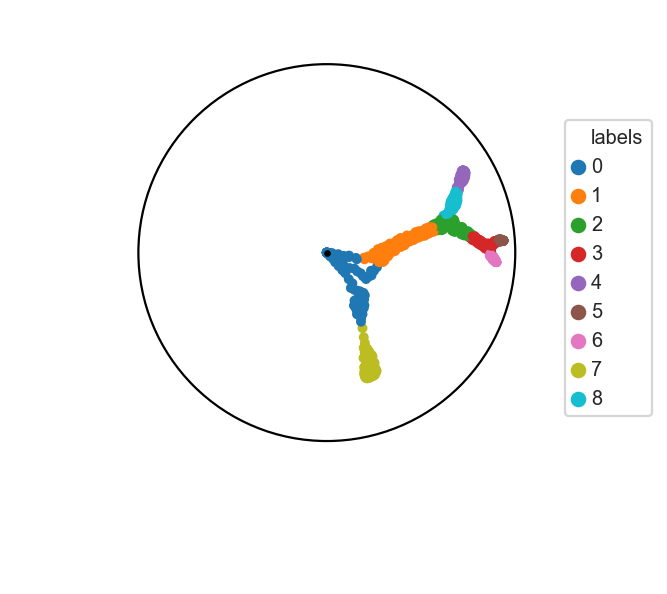

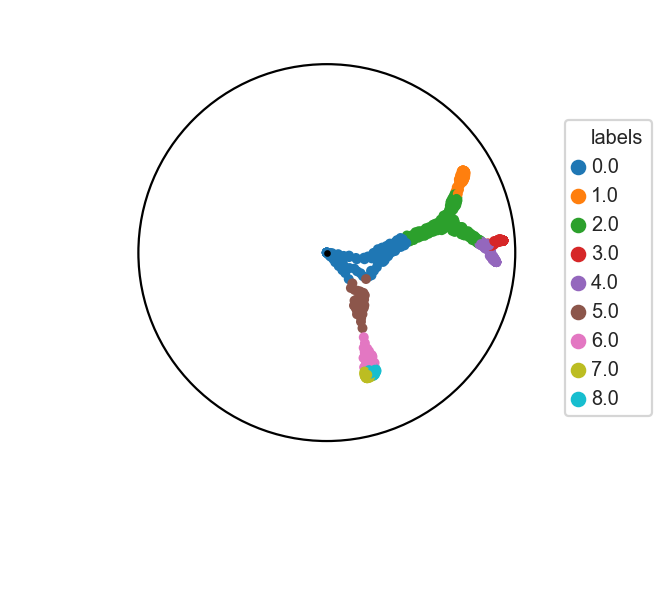

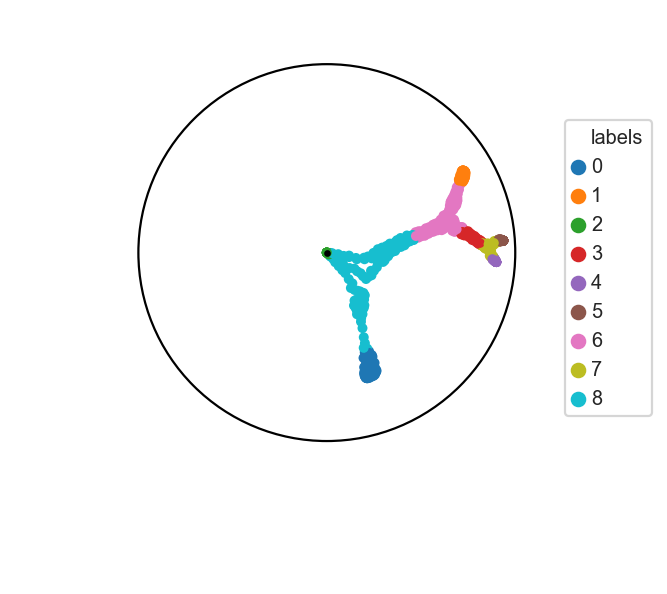

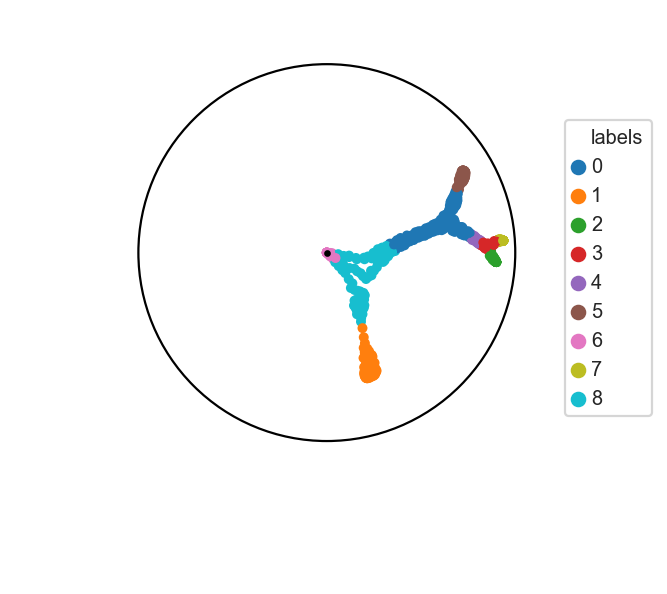

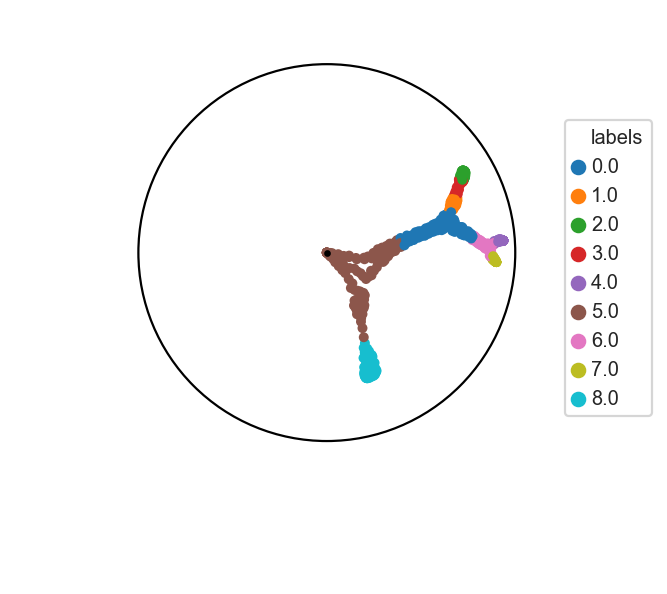

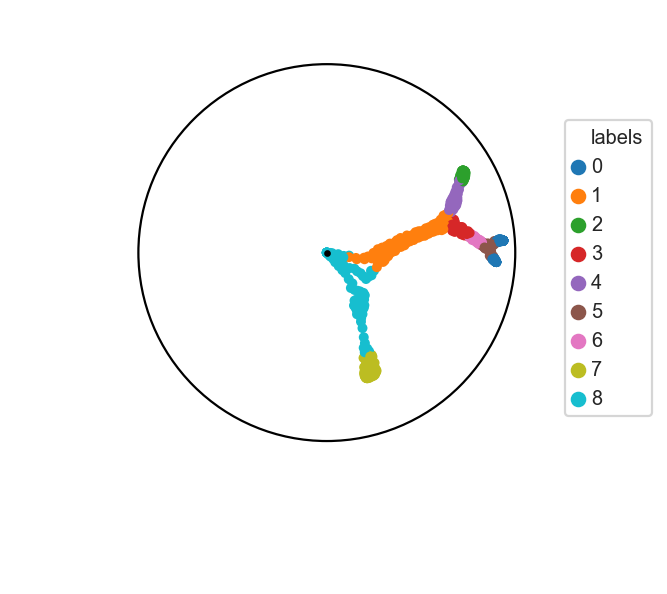

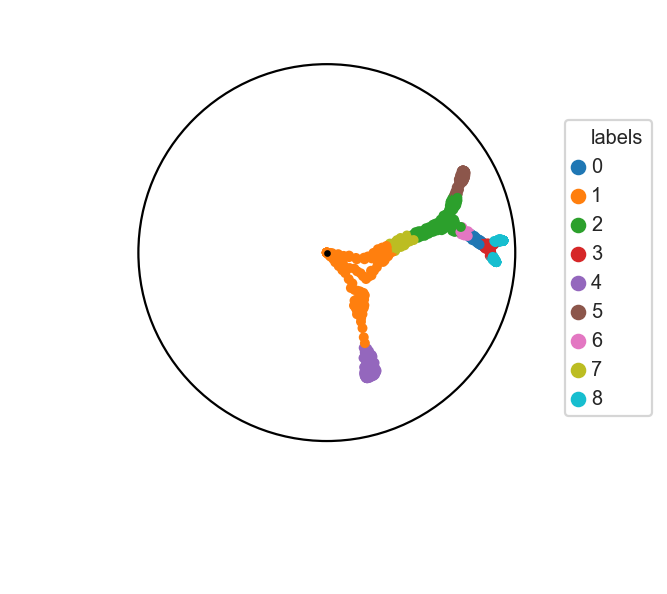

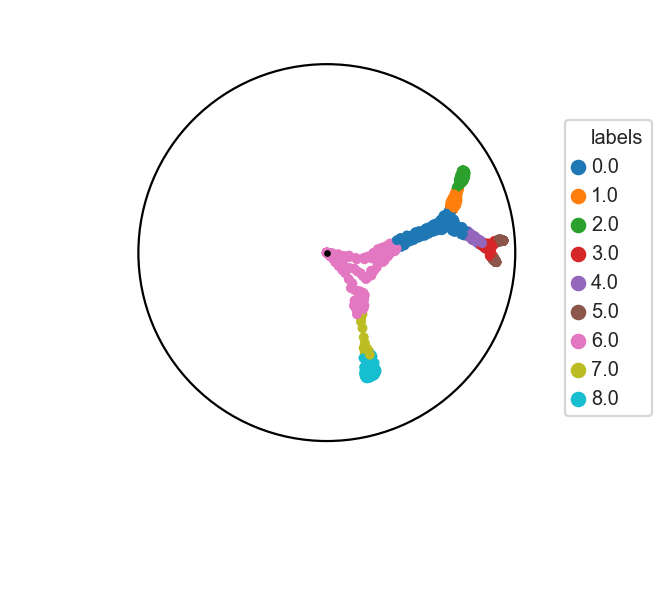

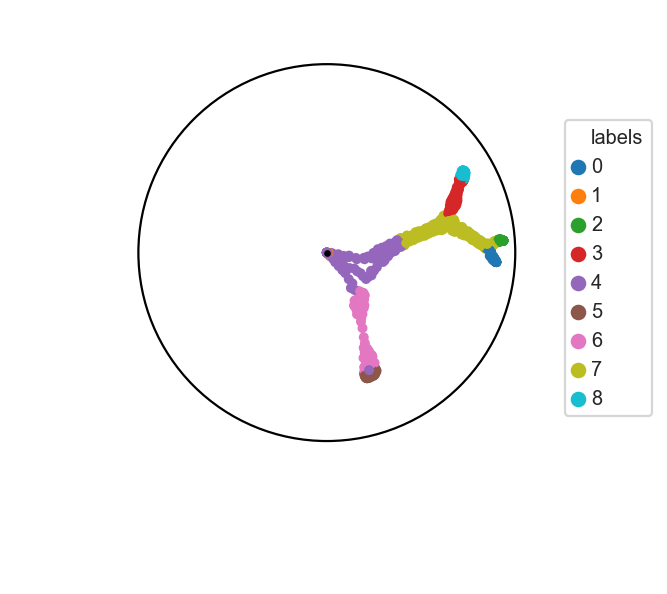

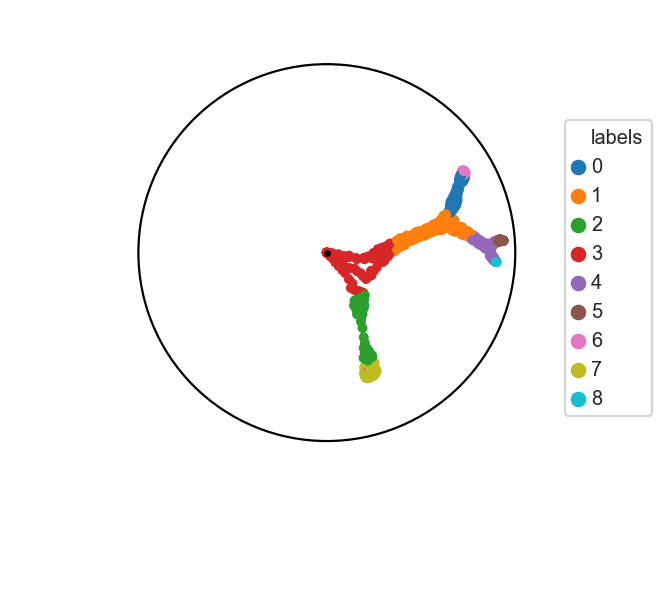

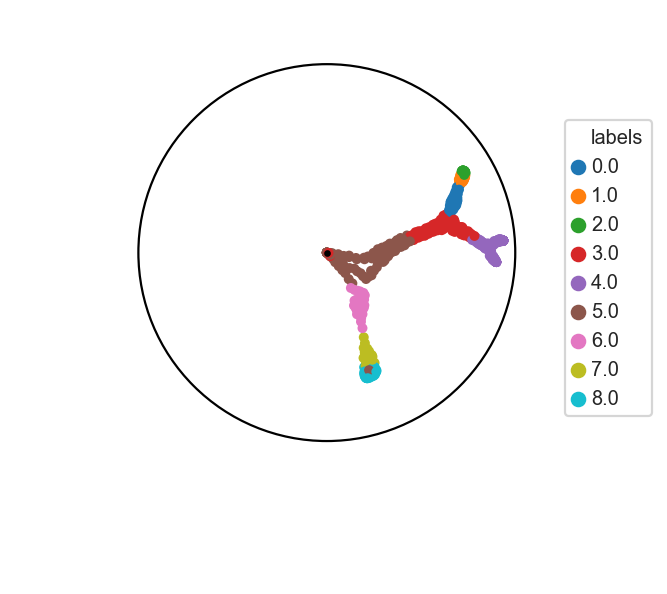

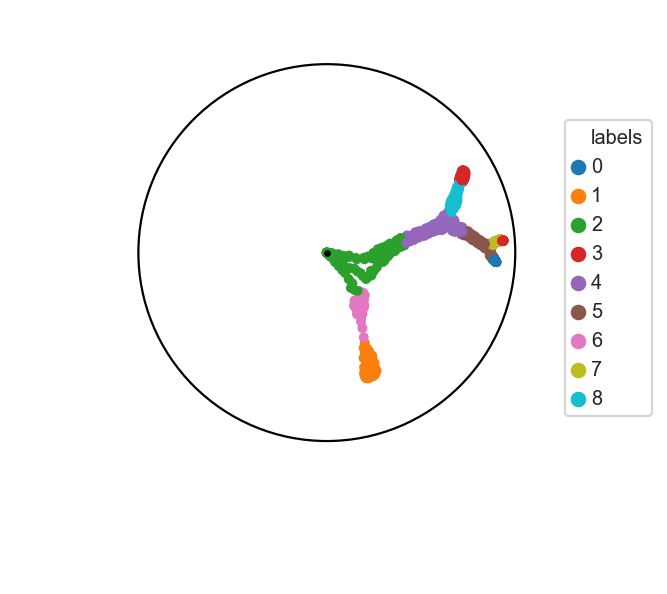

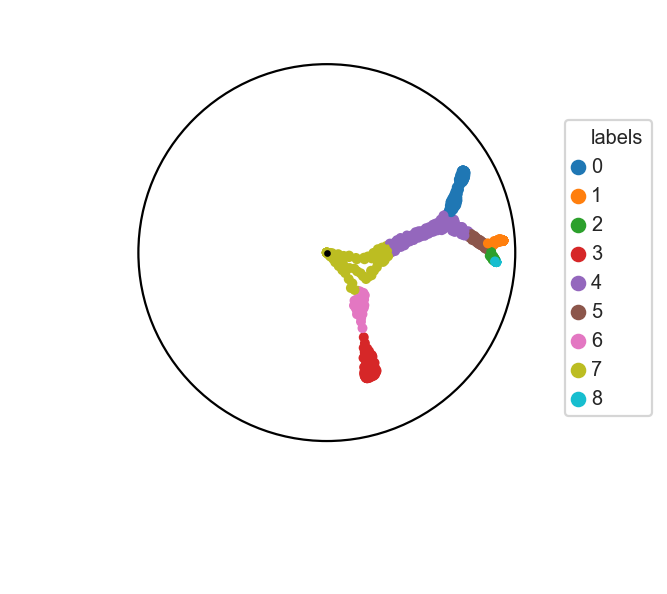

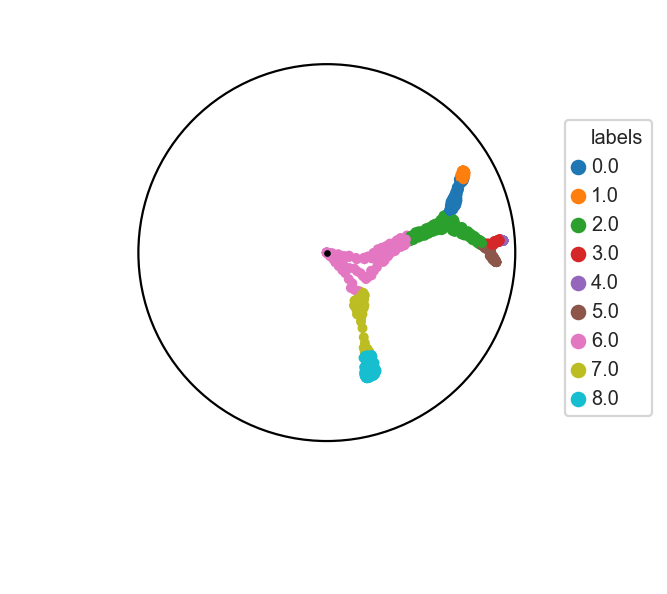

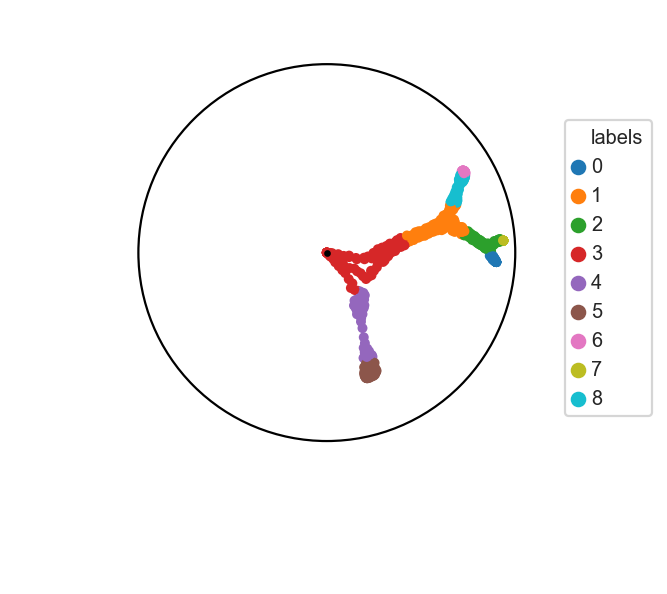

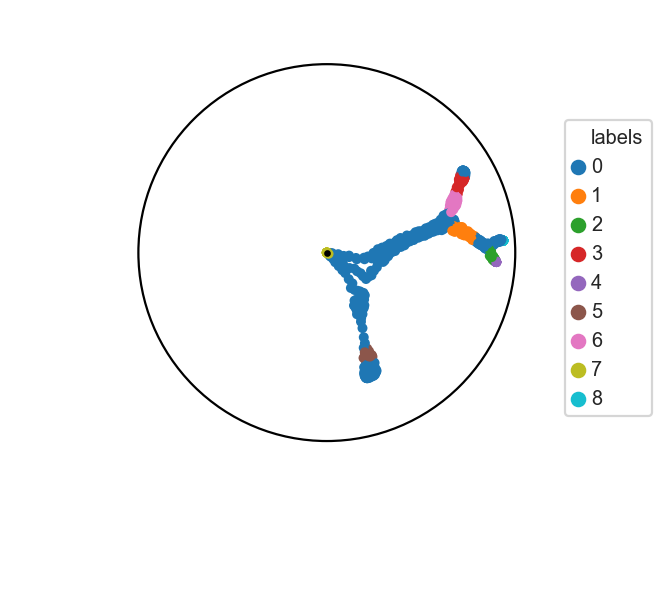

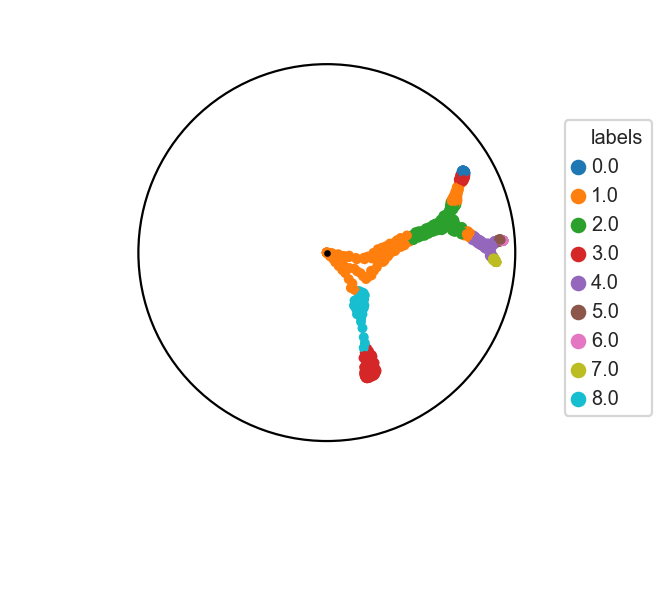

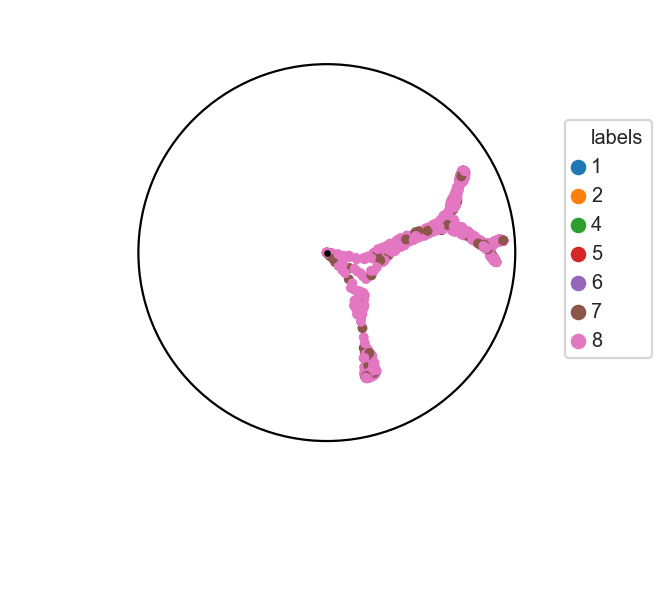

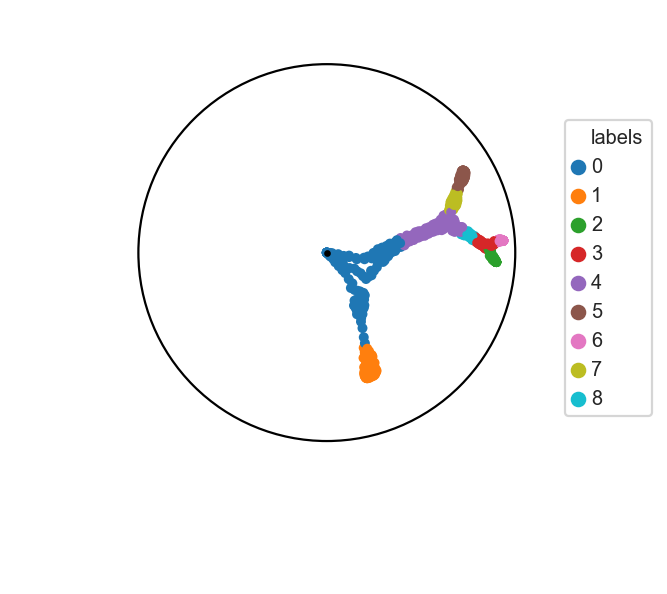

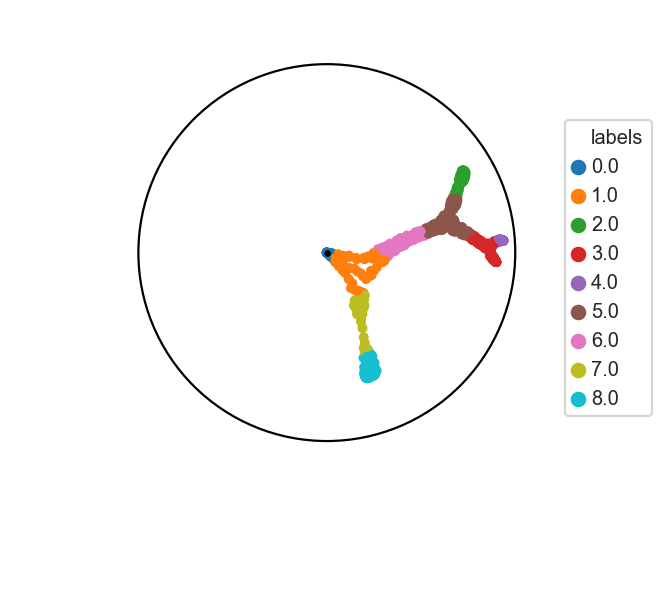

In [8]:
titles, scores2 = get_clustering_score_table()

# krumsiek11_blobs

... storing 'labels' as categorical


saving figure to file benchmarks/MyeloidProgenitors/paga.pdf


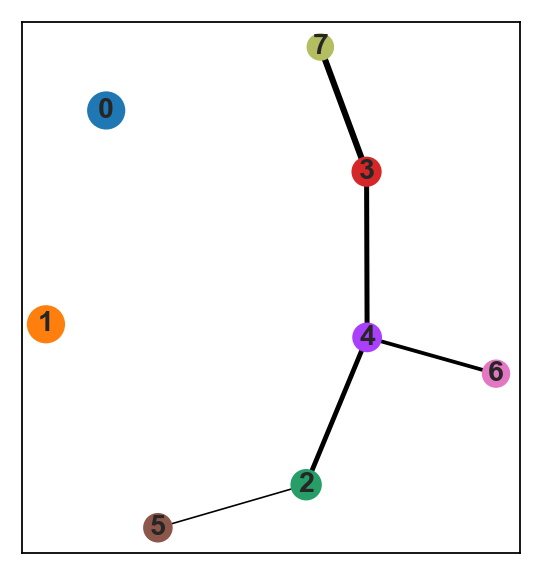

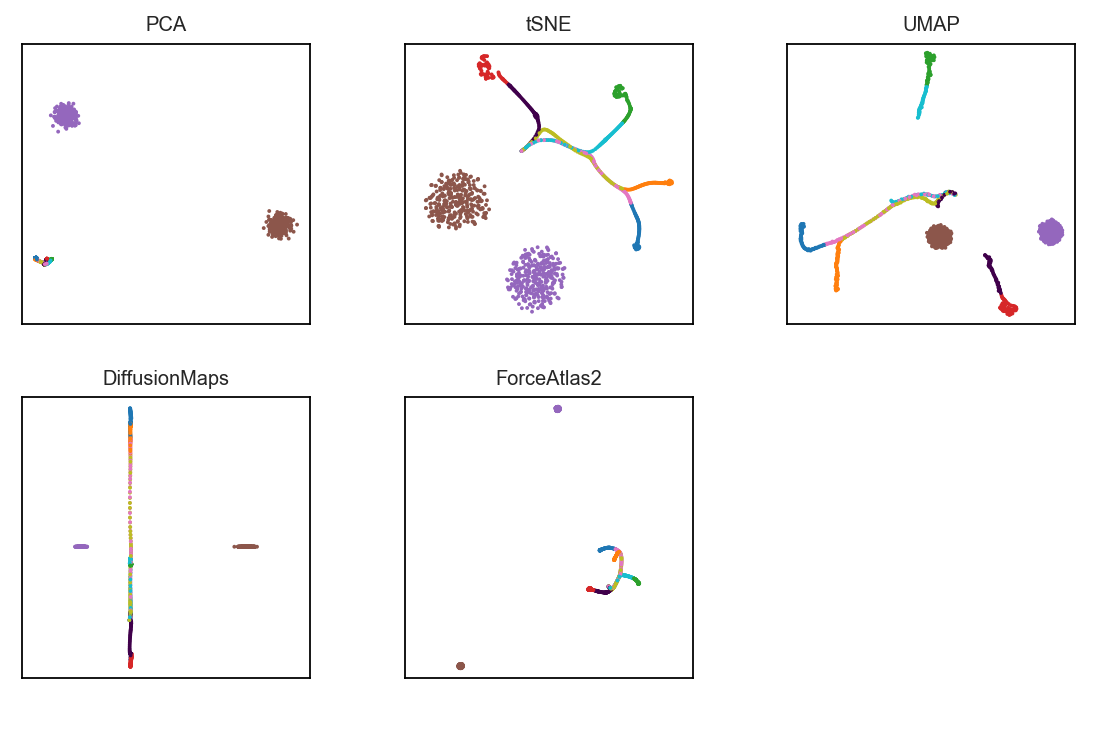

In [9]:
model_name = 'krumsiek11_blobs'
col_dict = None

fin = f"datasets/{model_name}"
fout = f"benchmarks/{model_name}"

data, true_labels, col_names = read_data(fin, normalize=False, n_pca=20)
true_lineages = true_labels
adata, iroot, louvain_labels = init_scanpy(data, col_names, 'root', true_labels, fout, k=30)
true_labels[true_labels == 'root'] = 'progenitorMo'
# true_labels[true_labels == 'Mo'] = 'progenitorMo'
# true_labels[true_labels == 'Ery'] = 'progenitorEry'
# true_labels[true_labels == 'Mk'] = 'progenitorMk'
# true_labels[true_labels == 'Neu'] = 'progenitorNeu'
true_labels[louvain_labels == '0'] = 'blob1'
true_labels[louvain_labels == '1'] = 'blob2'
true_lineages = true_labels

fsetting = 'krumsiek11_blobs_MFIsym30_klSym_sigma=1.00_gamma=2.00_lr=0.10_lrm=1.00_pca=20_epochs=10000_batchsize=160_connected'
input_file = f"results/{fsetting}"
poincare_coord = pd.read_csv(input_file + '.csv', sep=',', header=None).values
model = PoincareMaps(poincare_coord)
model.iroot = iroot
model.rotate()
model.get_distances()
plotBenchamrks(adata, true_labels, f"benchmarks/{model_name}")

ARI = 0.89
FMS = 0.91
ARI = 0.89
FMS = 0.91
ARI = 0.89
FMS = 0.91
ARI = 0.44
FMS = 0.52
ARI = 0.28
FMS = 0.46
ARI = 0.46
FMS = 0.64
ARI = 0.73
FMS = 0.77
ARI = 0.29
FMS = 0.41
ARI = 0.43
FMS = 0.60
ARI = 0.32
FMS = 0.44
ARI = 0.76
FMS = 0.81
ARI = 0.89
FMS = 0.91
ARI = 0.32
FMS = 0.43
ARI = 0.79
FMS = 0.84
ARI = 0.89
FMS = 0.91
ARI = 0.66
FMS = 0.71
ARI = 0.77
FMS = 0.81
ARI = 0.12
FMS = 0.44
ARI = 0.13
FMS = 0.38
ARI = 0.00
FMS = 0.39
ARI = 0.89
FMS = 0.91
ARI = 0.72
FMS = 0.76


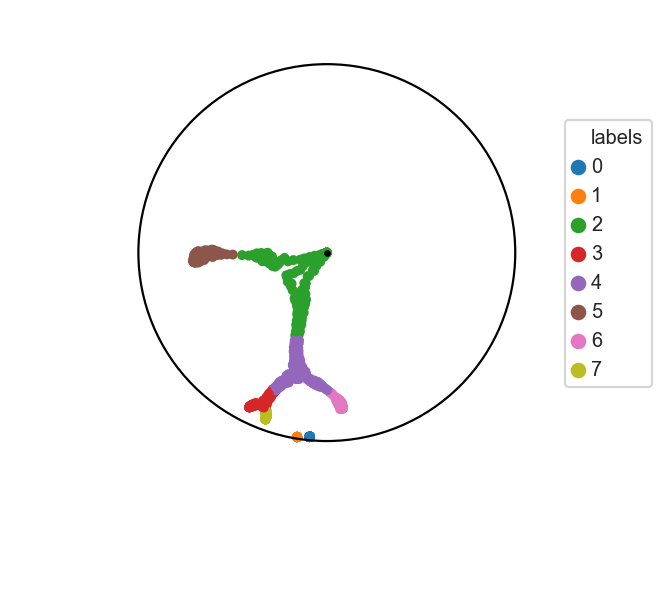

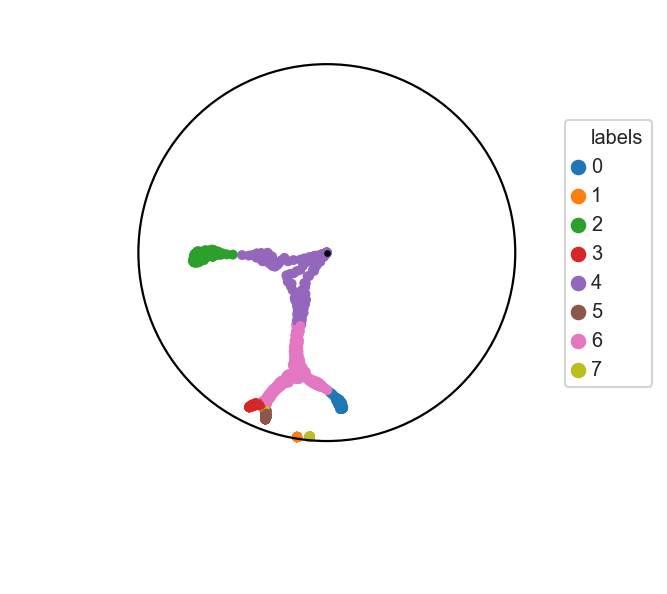

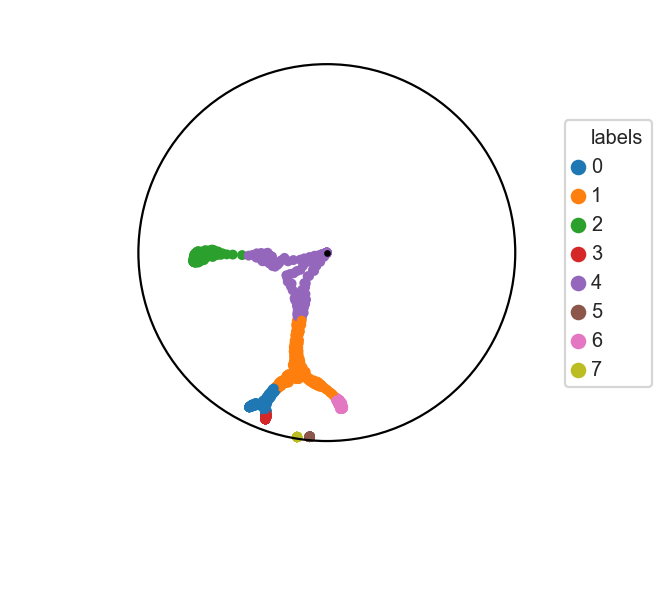

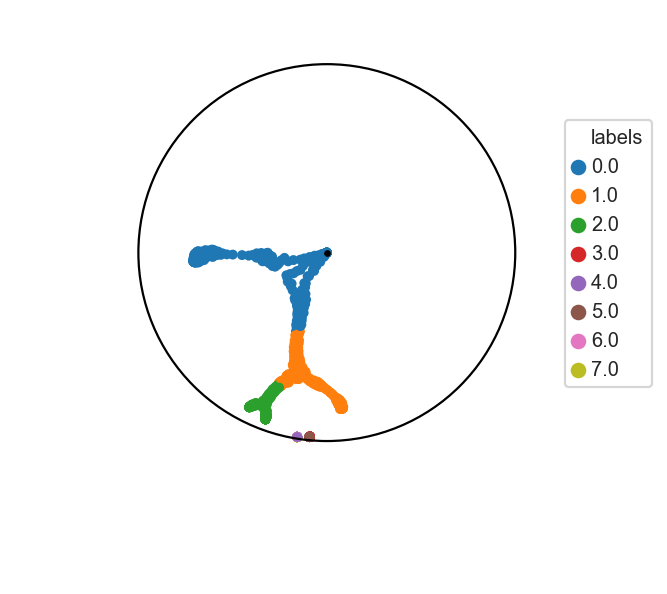

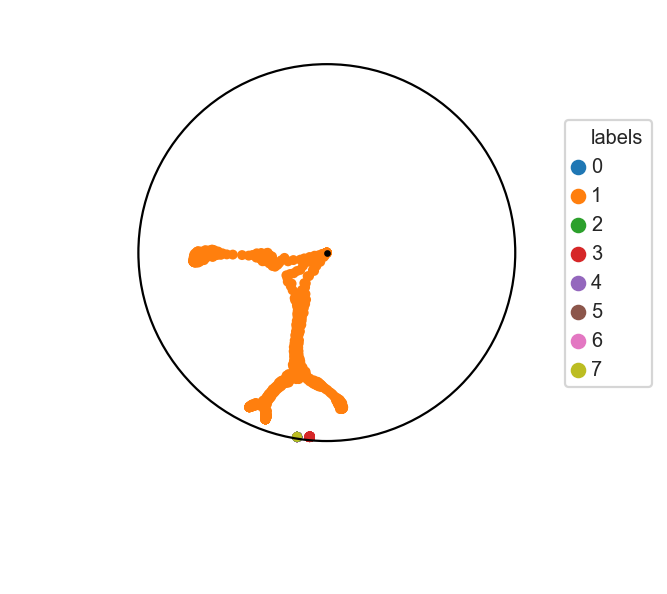

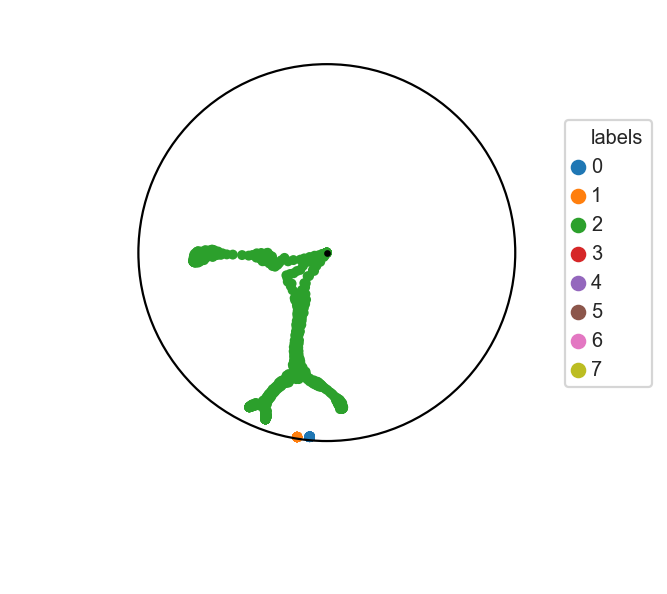

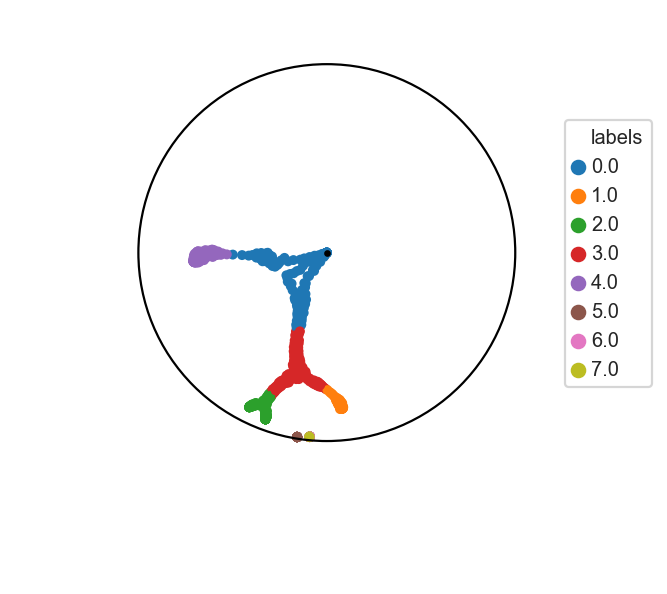

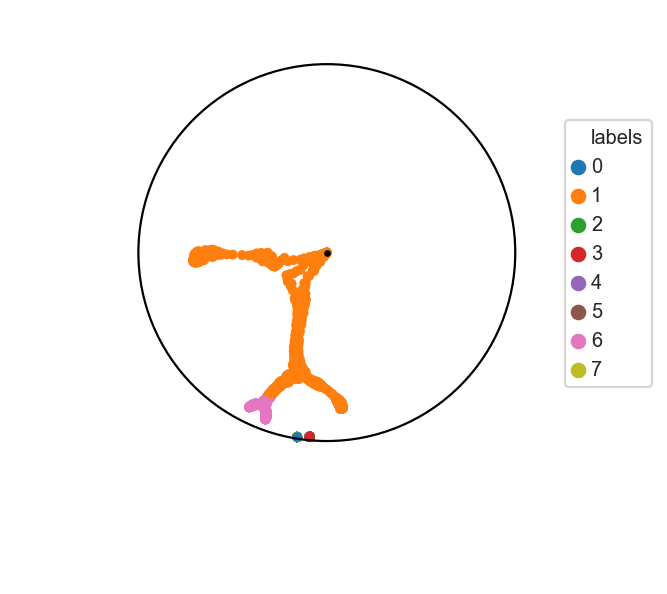

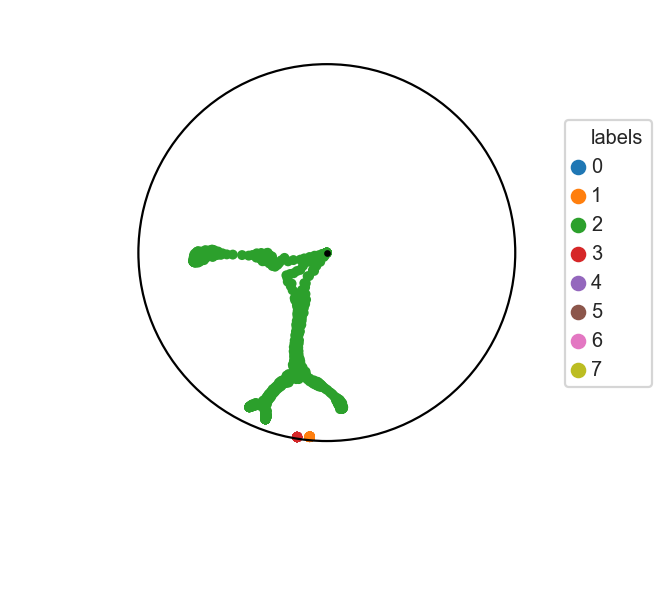

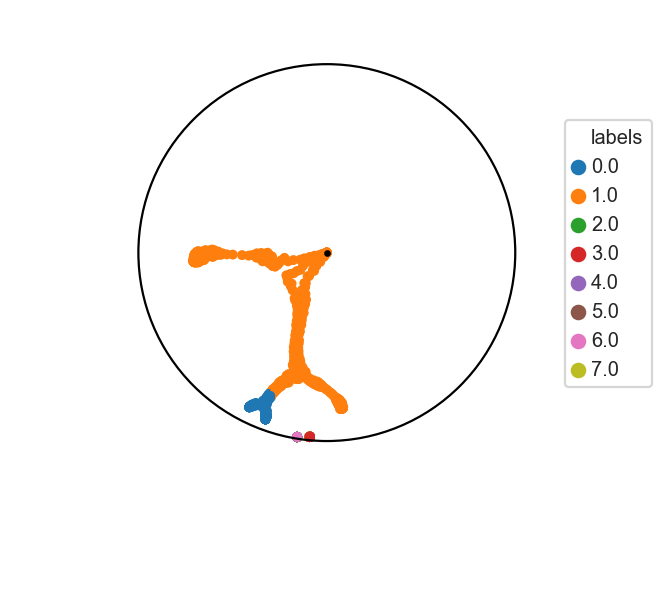

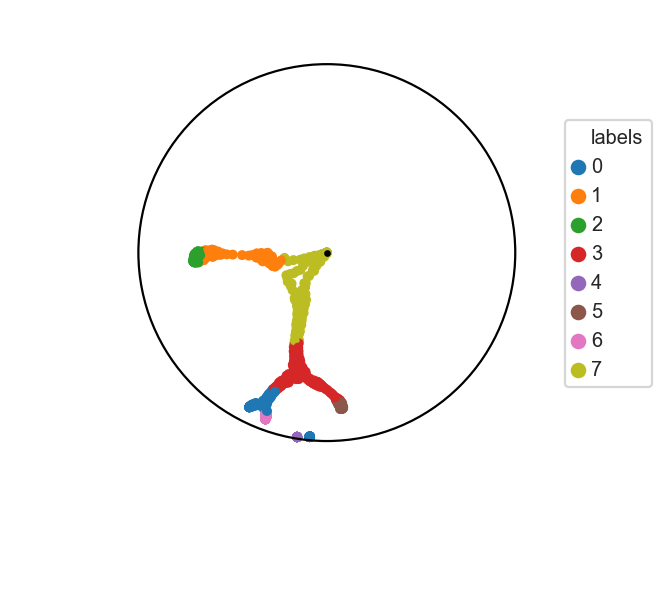

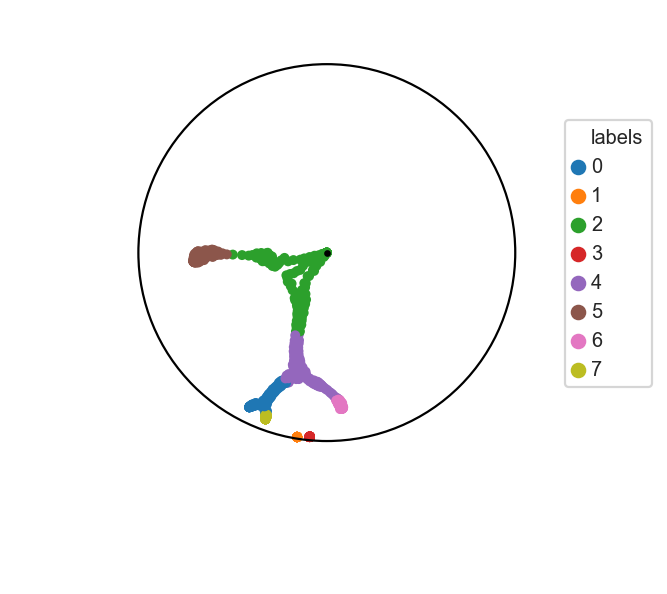

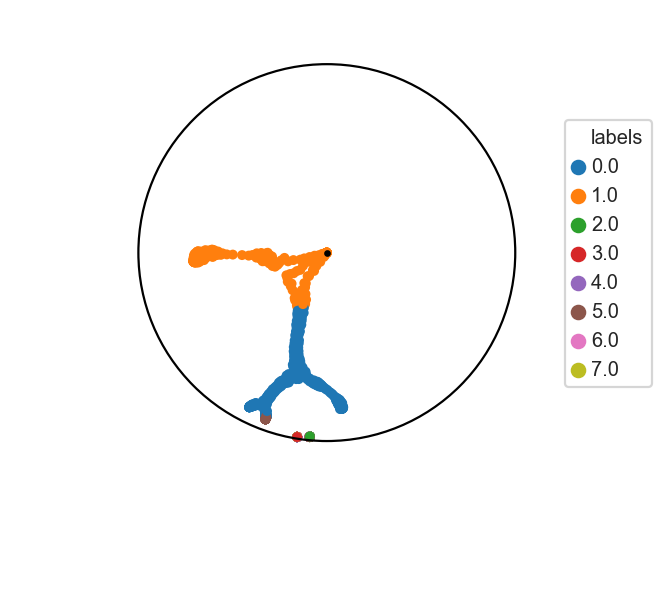

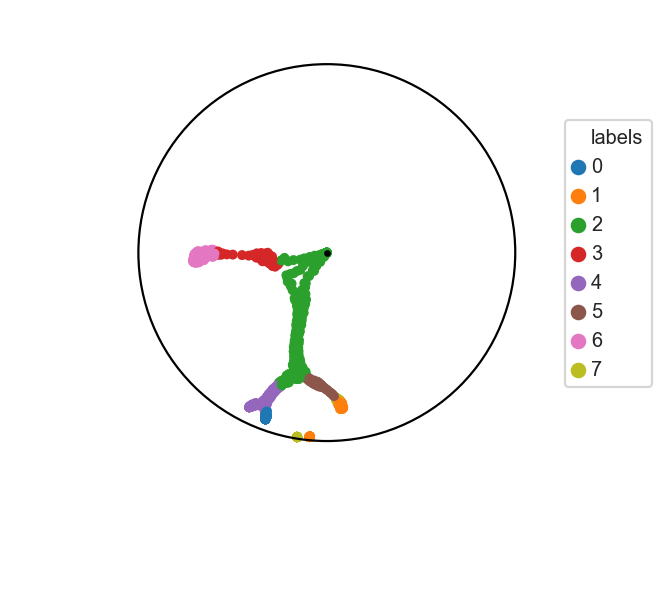

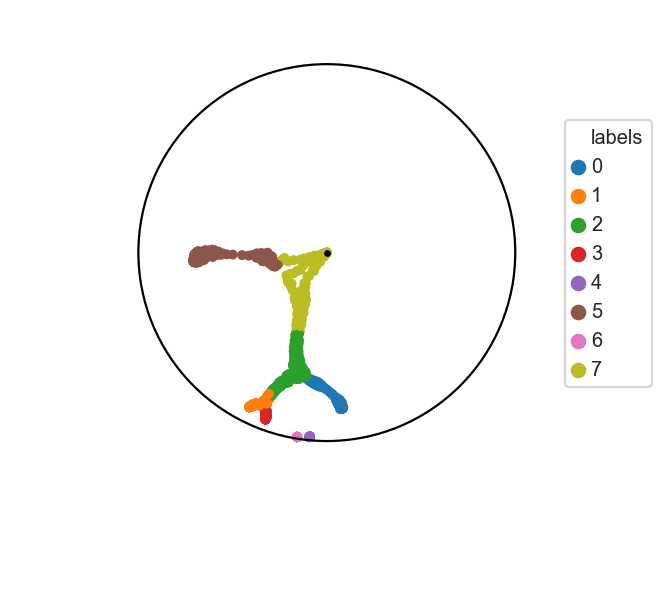

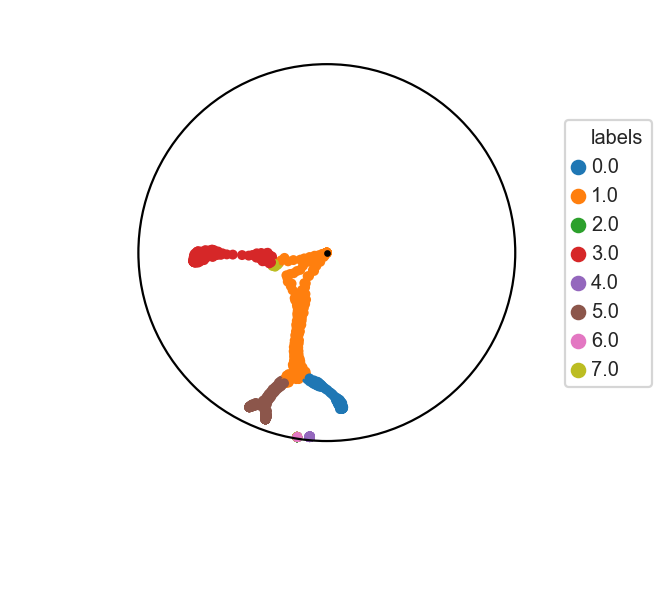

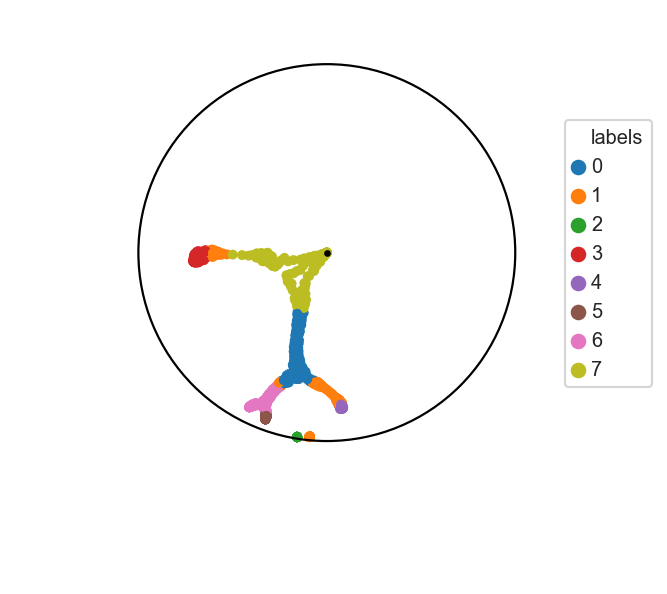

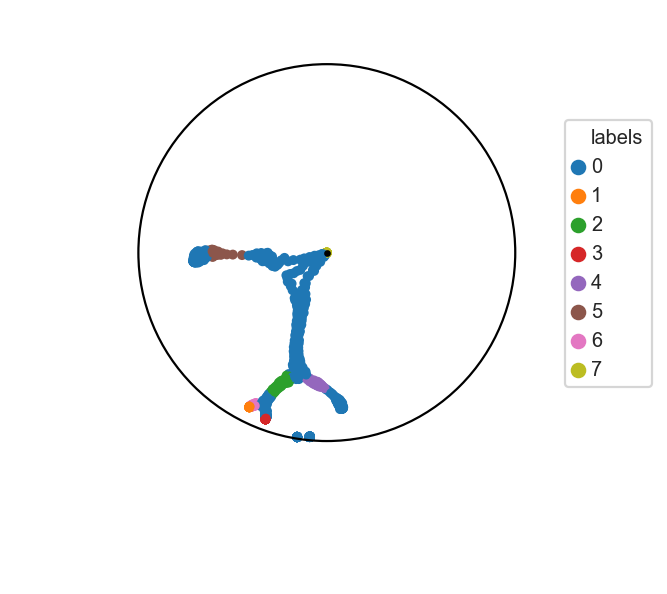

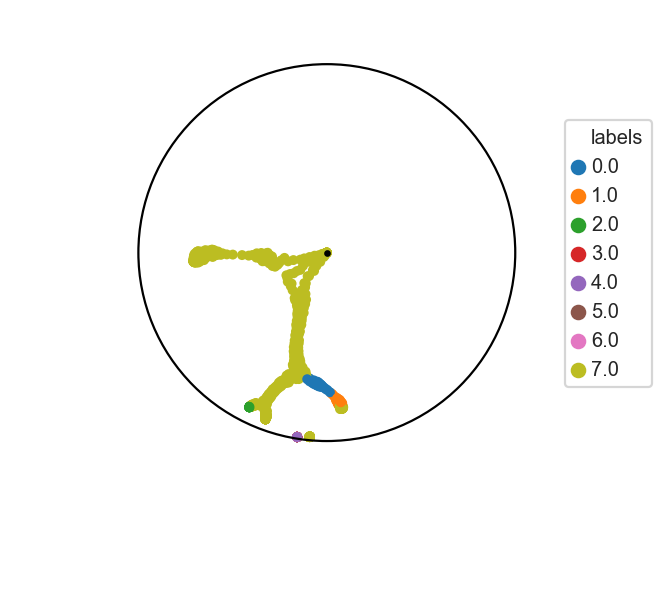

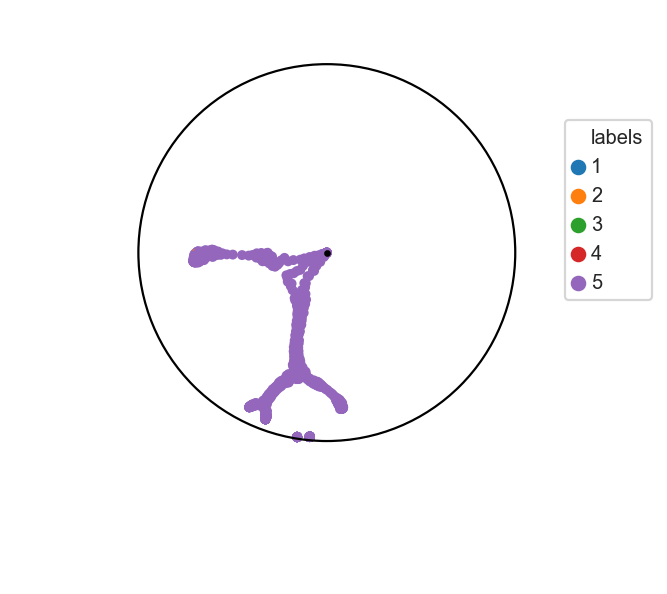

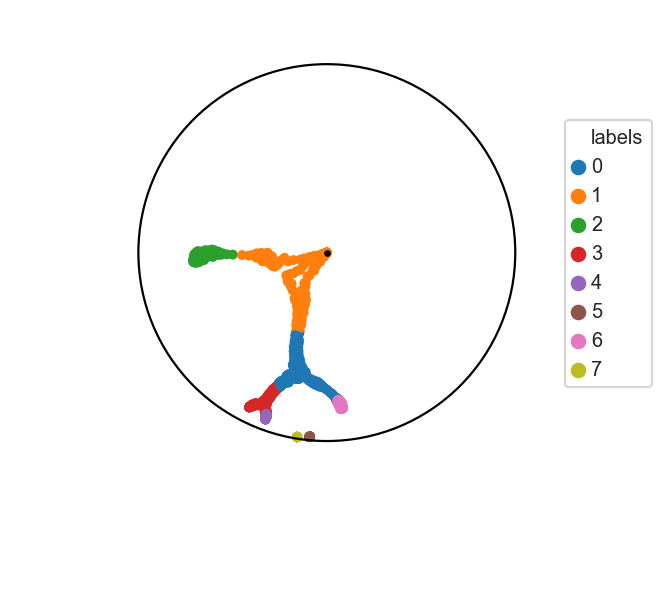

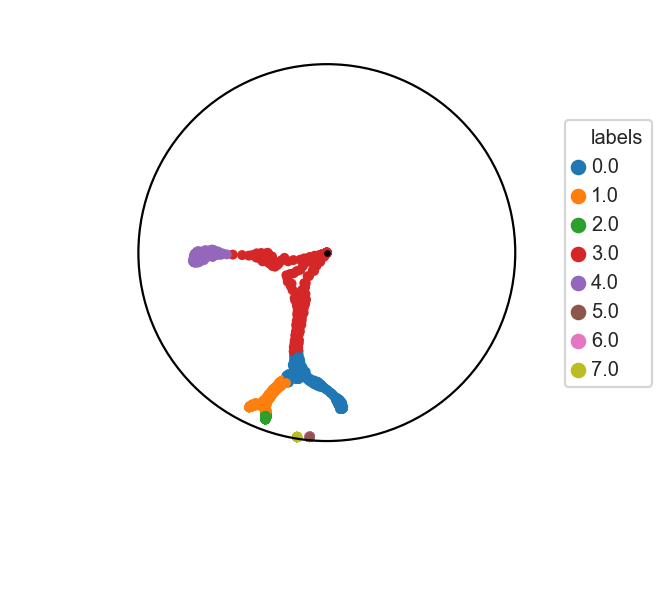

In [10]:
titles, scores3 = get_clustering_score_table()

In [11]:
from tabulate import tabulate
table = [["name", "ARS", "FMS", "ARS", "FMS", "ARS", "FMS"]]
for i, name in enumerate(titles):
    table.append([f"{name}", f"{scores1[i][0]:.2f}", f"{scores1[i][1]:.2f}",
                  f"{scores2[i][0]:.2f}", f"{scores2[i][1]:.2f}",
                 f"{scores3[i][0]:.2f}", f"{scores3[i][1]:.2f}"])

print(tabulate(table, tablefmt="latex"))

\begin{tabular}{lllllll}
\hline
 name                        & ARS  & FMS  & ARS   & FMS  & ARS  & FMS  \\
 louvain                     & 0.46 & 0.59 & 0.58  & 0.63 & 0.89 & 0.91 \\
 spectral Poincaré           & 0.39 & 0.54 & 0.62  & 0.67 & 0.89 & 0.91 \\
 agglomerative Poincaré      & 0.49 & 0.61 & 0.57  & 0.62 & 0.89 & 0.91 \\
 kmedoids Poincaré           & 0.38 & 0.53 & 0.54  & 0.60 & 0.44 & 0.52 \\
 spectral raw                & 0.18 & 0.39 & 0.52  & 0.58 & 0.28 & 0.46 \\
 agglomerative raw           & 0.12 & 0.42 & 0.54  & 0.60 & 0.46 & 0.64 \\
 kmedoids raw                & 0.19 & 0.41 & 0.55  & 0.61 & 0.73 & 0.77 \\
 spectral PCA                & 0.18 & 0.39 & 0.53  & 0.59 & 0.29 & 0.41 \\
 agglomerative PCA           & 0.12 & 0.42 & 0.48  & 0.55 & 0.43 & 0.60 \\
 kmedoids PCA                & 0.20 & 0.42 & 0.49  & 0.56 & 0.32 & 0.44 \\
 spectral tSNE               & 0.45 & 0.58 & 0.61  & 0.66 & 0.76 & 0.81 \\
 agglomerative tSNE          & 0.45 & 0.59 & 0.54  & 0.59 & 0.89 & 0